<a href="https://colab.research.google.com/github/ncgomez17/Deep_Learning/blob/master/Keras/Aprendiendo_Keras5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este caso se creará un modelo para predecir la eficiencia del combustible en automóviles de la década de los años sesenta.Los datos que usaremos vendrán de un conjunto de datos de la Universidad de California en Irvine y disponen de un conjunto de datos llamado auto MPG.

Lo primero que haremos será descargar los datos y luego prepararlos para poder alimentar el modelo que creemos.

In [19]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2.4.1


In [20]:
## Descargamos el dataset Auto MPG
dataset_path = tf.keras.utils.get_file("auto-mpg.data","https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [21]:
## Usamos pandas para la manipulación y análisis de datos
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ",skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [22]:
## comprobamos si falta algún valor para garantizar que nuestros datos son correctos
print(dataset.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Como podemos observar faltan los valores de Horsepower para 6 muestras.En las redes neuronales no podemos estos valores vacíos.Podemos estimar los campos vacíos con algún estimador(**ScikitLearn**) o eliminar las características o muestras con campos vacíos.Para este ejemplo optaremos por la última opción.

In [23]:
dataset = dataset.dropna()
## Cambiamos la columna origin por tres columnas nuevas

Origin = dataset.pop('Origin')

dataset['USA'] = (Origin == 1) *1.0
dataset['Europe'] = (Origin == 2) *1.0
dataset['Japan'] = (Origin == 3) *1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Lo siguiente será separar los datos para entrenar y evaluar el modelo.

In [25]:
## Repartimos los datos
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

##También separamos la columna de datos que contiene los valores que queremos predecir(MPG)
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

##Inspeccionamos los datos de entrada
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Cabe destacar que viendo el resultado podemos deducir que son bastante diferentes los rangos de cada característica.Por lo que tendremos que normalizar las características para que el entrenamiento sea más efectivo.

In [26]:
## Función de nomalización
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']

Esta función reescala las características en un rango [0,1] y centra las columnas de características con respecto a una media 0 con desviación estándar 1, de forma que las columnas de características tengan los mismos parámetros que una distribución normal estándar.

In [28]:
## Aplicamos la función de normalización a los datos de entrenamiento y de prueba
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
## Comprobamos lo que hemos realizado
normed_train_stats = normed_train_data.describe().transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


In [31]:
## Procedemos a definir el modelo
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu',
                  input_shape=[len(train_dataset.keys())]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()

## Inspeccionamos la arquitectura de la red
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Ahora configuraremos el modelo, para ello tenemos que tener en cuenta la función de pérdida y el optimizador.

In [33]:
## Configuramos el modelo
optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae','mse'])

##Probamos con un epoch de 1000 para ver como se provoca un sobreentrenamiento
EPOCHS = 1000
history= model.fit(
    normed_train_data,train_labels,
            epochs=EPOCHS, validation_split = 0.2, verbose=1
)

Epoch 1/1000
8/8 [==============================] - 1s 41ms/step - loss: 579.4427 - mae: 22.9753 - mse: 579.4427 - val_loss: 569.3231 - val_mae: 22.5529 - val_mse: 569.3231
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 540.1847 - mae: 21.9658 - mse: 540.1847 - val_loss: 522.3920 - val_mae: 21.4842 - val_mse: 522.3920
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 494.5518 - mae: 20.7482 - mse: 494.5518 - val_loss: 468.9049 - val_mae: 20.2326 - val_mse: 468.9049
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 456.6260 - mae: 19.9808 - mse: 456.6260 - val_loss: 410.2592 - val_mae: 18.7524 - val_mse: 410.2592
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 396.5753 - mae: 18.3625 - mse: 396.5753 - val_loss: 347.9204 - val_mae: 17.0337 - val_mse: 347.9204
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 324.8165 - mae: 16.6446 - mse: 324.8165 - val_loss: 287.0138 - val_

In [35]:
## Evaluamos el modelo
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.754732,1.037082,2.754732,8.248658,2.222059,8.248658,995
996,2.719367,1.060633,2.719367,8.414820,2.243119,8.414820,996
997,2.785060,1.061102,2.785060,8.398586,2.272278,8.398586,997
998,2.727185,1.080337,2.727185,8.276084,2.218070,8.276084,998
999,2.777972,1.079490,2.777972,8.025998,2.237157,8.025998,999


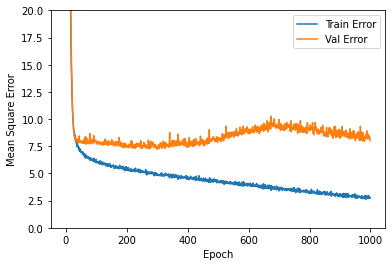

In [36]:
## Observamos gráficamente como evolucionan estos valores durante el entrenamiento

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],label ='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Añadiremos un callback como argumento en el método fit.

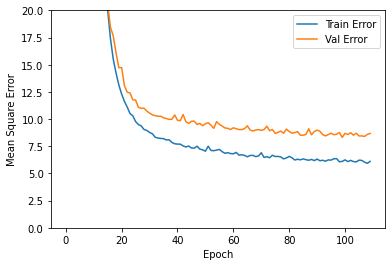

In [38]:
model = build_model()

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae','mse'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop])

plot_history(history)

Por último veremos como generaliza el modelo al usar el conjutno de datos de prueba.Esto nos indicará que podemos esperar del modelo cuando se use en el mundo real.

In [39]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print('Testing set Mean Abs Error:{:5.2f} MPG'.format(mae))
print('Testing set Mean Sqr Error:{:5.2f} MPG'.format(mse))

3/3 [==============================] - 0s 3ms/step - loss: 5.8354 - mae: 1.9394 - mse: 5.8354
Testing set Mean Abs Error: 5.84 MPG
Testing set Mean Sqr Error: 1.94 MPG


Estos resultados nos indican que tienen un error de 5.84millas por galón, en el caso de MAE corresponde con 2.26 km por litro de error